##### 캐글 노트북에서 진행

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# yml파일, 경로설정
%cd ../

In [3]:
!mkdir tmp

In [4]:
%cd tmp

In [5]:
!git clone https://github.com/ultralytics/yolov5

In [6]:
%cd yolov5

In [7]:
%pip install -qr requirements.txt

In [8]:
%cd ../ 

In [10]:
!pip install --upgrade wandb

In [11]:
import wandb
wandb.login()

In [12]:
TRAIN_PATH = 'input/siim-covid19-resized-to-256px-jpg/train/'
IMG_SIZE = 256
BATCH_SIZE = 16
EPOCHS = 10

In [13]:
%cd ../

In [14]:
df = pd.read_csv("input/siim-covid19-detection/train_image_level.csv")
df

In [15]:
df["label"][0]

In [16]:
df["label"].apply(lambda x:x.split()[0]).value_counts()

In [17]:
df["id"] = df["id"].apply(lambda x:x.split("_")[0])
df

In [18]:
pd.options.display.max_colwidth = 999
df["path"] = TRAIN_PATH + df["id"] + ".jpg"
df

In [19]:
df["image_label"] = df["label"].apply(lambda x:x.split()[0])
df

In [20]:
meta_df = pd.read_csv("input/siim-covid19-resized-to-256px-jpg/meta.csv")
meta_df

In [21]:
train_meta_df = meta_df[meta_df["split"] == "train"]
train_meta_df

In [22]:
train_meta_df = train_meta_df.drop(columns = "split")
train_meta_df

In [23]:
train_meta_df = train_meta_df.rename(columns = {"image_id": "id"})
#train_meta_df.columns = ["id","dim0","dim1"]
train_meta_df

In [24]:
df = pd.merge(df,train_meta_df, on = "id", how = "left")
df

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_valid = train_test_split(df, test_size = 0.2,random_state = 82, stratify = df["image_label"])

In [26]:
X_train.loc[:, 'split'] = 'train' # X_train["split"] = "train"
X_valid.loc[:, 'split'] = 'valid'

df = pd.concat([X_train, X_valid]).reset_index(drop=True)
df

In [27]:
import os
os.makedirs("tmp/covid/images/train",exist_ok = True)
os.makedirs("tmp/covid/images/val",exist_ok = True)
os.makedirs("tmp/covid/labels/train",exist_ok = True)
os.makedirs("tmp/covid/labels/val",exist_ok = True)

In [28]:
!ls tmp/covid/images

In [29]:
from tqdm import tqdm
from shutil import copyfile
for i in tqdm(range(len(df))):
    row = df.loc[i]
    if row["split"] == "train":
        copyfile(row["path"],"tmp/covid/images/train/" + row["id"] + ".jpg")
    else:
        copyfile(row["path"],"tmp/covid/images/val/" + row["id"] + ".jpg")

In [30]:
import yaml 
data_yaml = {"train":"../covid/images/train","val":"../covid/images/val","nc":2,"names":["none","opacity"]}
data_yaml

In [31]:
with open("tmp/yolov5/data/data.yaml","w") as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style = True)

In [32]:
%cat tmp/yolov5/data/data.yaml

In [33]:
df.head(2)

In [35]:
def get_bbox(row):
    bboxes = []
    bbox = []
    for i , j in enumerate(row["label"].split()):
        if (i % 6 == 0) | (i % 6 == 1): 
            continue
        bbox.append(float(j))
        if i % 6 == 5: 
            bboxes.append(bbox)
            bbox = []
    return bboxes

In [36]:
def scale_bbox(row,bboxes):
    scale_x = IMG_SIZE / row['dim1']
    scale_y = IMG_SIZE / row['dim0']
    scaled_bboxes = []
    for bbox in bboxes:
        x_min = int(np.round(bbox[0] * scale_x))
        y_min = int(np.round(bbox[1] * scale_y))
        x_max = int(np.round(bbox[2] * scale_x))
        y_max = int(np.round(bbox[3] * scale_y))
        scaled_bboxes.append([x_min,y_min,x_max,y_max])
        
    return scaled_bboxes

In [37]:
def get_yolo_format_bbox(IMG_W,IMG_H,scale_bboxes):
    yolo_boxes = []
    for bbox in scale_bboxes:
        width = bbox[2] - bbox[0]
        height = bbox[3] - bbox[1]
        x_center =  bbox[0] + int(np.round(width / 2))
        y_center =  bbox[1] + int(np.round(height / 2))
        yolo_boxes.append([x_center/IMG_W,y_center/IMG_H,width/IMG_W,height/IMG_H])
    return yolo_boxes

In [38]:
for i in tqdm(range(len(df))):
    row = df.loc[i]
    image_id = row["id"]
    split = row["split"]
    label = row["image_label"]
    if split == "train":
        file_name = "tmp/covid/labels/train/" + image_id + ".txt"
    else:
        file_name = "tmp/covid/labels/val/" + image_id + ".txt"
    
    if label == "opacity":
        bboxes = get_bbox(row)
        scale_bboxes = scale_bbox(row,bboxes)
        yolo_bboxes = get_yolo_format_bbox(IMG_SIZE,IMG_SIZE,scale_bboxes)
        with open(file_name,"w") as f:
            for bbox in yolo_bboxes:
                bbox = [1] + bbox
                bbox = [str(i) for i in bbox]
                bbox = " ".join(bbox)
                f.write(bbox)
                f.write("\n")

In [39]:
%cd tmp/yolov5

In [40]:
!ls

In [41]:
!python train.py --img 256 --batch 32 --epochs 3 --data data.yaml --weights yolov5l.pt --save_period 1 --project kaggle_ssim_covid

In [42]:
test_path = "/kaggle/input/siim-covid19-resized-to-256px-jpg/test/"

In [43]:
!ls

In [44]:
%cd kaggle_ssim_covid

In [45]:
!ls

In [46]:
%cd exp

In [47]:
!ls

In [48]:
%cd weights

In [49]:
!ls

In [50]:
best_path = "kaggle_ssim_covid/exp/weights/best.pt"

In [57]:
%cd ../../../

In [63]:
!ls kaggle_ssim_covid/exp/weights

In [64]:
!python detect.py --weights {best_path} --source {test_path} --img 256 --conf 0.274 --max-det 3 --save-txt --save-conf

In [65]:
!ls runs/detect/exp3/labels

In [66]:
%cat runs/detect/exp3/labels/"00fc8fc35dc1.txt"

In [67]:
prediction_files = os.listdir("runs/detect/exp3/labels/")
len(prediction_files)

In [68]:
sub = pd.read_csv("/kaggle/input/siim-covid19-detection/sample_submission.csv")
sub

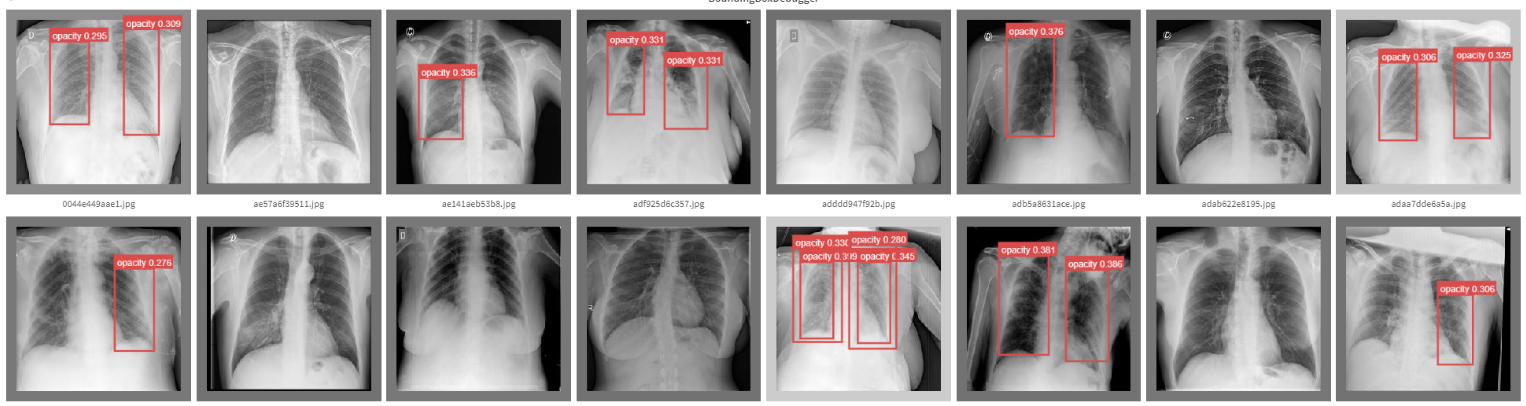